In [3]:
#import libraries
import numpy as np
import pandas as pd
import sys
import math
import matplotlib.pyplot as plt
import random
from scipy.stats import chisquare

In [4]:
def benford_x_digit(rawdata,digit):
    data_nonzero=filter(lambda n: n !=0. , rawdata)
    data=list(data_nonzero)
    BFD= [math.log10(1.0+1.0/n) for n in range (10**(digit-1),10**digit)]
    data_count={}
    for i in range(10**(digit-1),10**digit):
        data_count[i]=0      
    data_xdigits=[int(str(abs(x*1000))[0:digit]) for x in data]
    for i in range(len(data_xdigits)):
            data_count[data_xdigits[i]]=data_count[data_xdigits[i]]+1
    list_tuples=sorted(data_count.items())
    data_count=[i[1] for i in list_tuples]
    total_count=sum(data_count)
     
    expected_count=[p * total_count for p in BFD]
    #We are not rounding/flooring here because it may be useful to have the 
    #fractions even if it doesnt make sense in real life, just to reconcile totals
    #in the dataframe wrapper I am rounding it anyway.    
    
    #conveniently, in python a function can return several values, in this case
    #we are returning the data count, expected count and expected frequency for 
    #the first n digits and raw data provided. 
    return  data_count, expected_count, BFD
def benford_x_digit_to_dataframe(rawdata,digit):
    c,e,p = benford_x_digit(data,1)
    return pd.DataFrame(tuple(zip((1,2,3,4,5,6,7,8,9),c,np.around(e),p)),columns=['Digit','Count','Exp_count','Exp_freq'])

#Now a test with dummy data to see how it works without having to load external data
print("Test values:")
data=[0,0,0,0,-1,11,1.11,0.1111,1,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,4,4,4,5,5,5,6,6,7,7,8,8,9,9]
# This list should match exactly the expected count, i.e. 11,6,4,3,3,2,2,2,2
benford_x_digit_to_dataframe(data,1)


Test values:


,Digit,Count,Exp_count,Exp_freq
0,1,11,11.0,0.301030
1,2,6,6.0,0.176091
2,3,4,4.0,0.124939
3,4,3,3.0,0.096910
4,5,3,3.0,0.079181
5,6,2,2.0,0.066947
6,7,2,2.0,0.057992
7,8,2,2.0,0.051153
8,9,2,2.0,0.045757


In [9]:
def plot_benford(data,digit):   
    data_count, expected_count, p =benford_x_digit(data,digit)
    y1 = expected_count
    y2 = data_count
    x= np.arange(10**(digit-1),10**digit)
    bins = np.linspace(1, 10)
    width=.35
    plt.bar(x, y2, width, label="Actual")
    plt.bar(x+width, y1, width, label="Benford")
    plt.xticks(x+width/2 , x)
    plt.legend(loc='upper right')
    plt.show()

In [10]:
df= pd.read_excel("./test_data/data.xlsx")
df

,Unnamed: 0,field1,field2,field3
0,0,-54,4888,-5158
1,1,6,-2316,865
2,2,-16,-84,20
3,3,82,-12138,-11577
4,4,28,-144,-77
...,...,...,...,...
99995,99995,44,-3521,-49
99996,99996,-3,-21,56
99997,99997,58,-2291,2189
99998,99998,73,10228,-10975


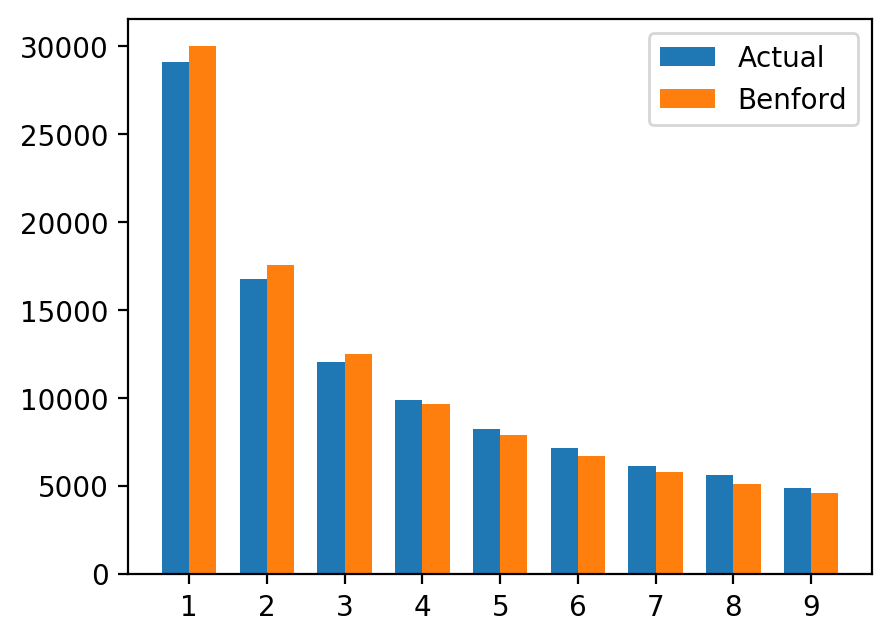

In [11]:
digit=1
data=df["field3"].tolist()
plot_benford(data,digit)

In [12]:
#if we want the actual data
benford_x_digit_to_dataframe(data,1)

,Digit,Count,Exp_count,Exp_freq
0,1,29102,30026.0,0.301030
1,2,16751,17564.0,0.176091
2,3,12039,12462.0,0.124939
3,4,9870,9666.0,0.096910
4,5,8247,7898.0,0.079181
5,6,7116,6677.0,0.066947
6,7,6133,5784.0,0.057992
7,8,5630,5102.0,0.051153
8,9,4855,4564.0,0.045757


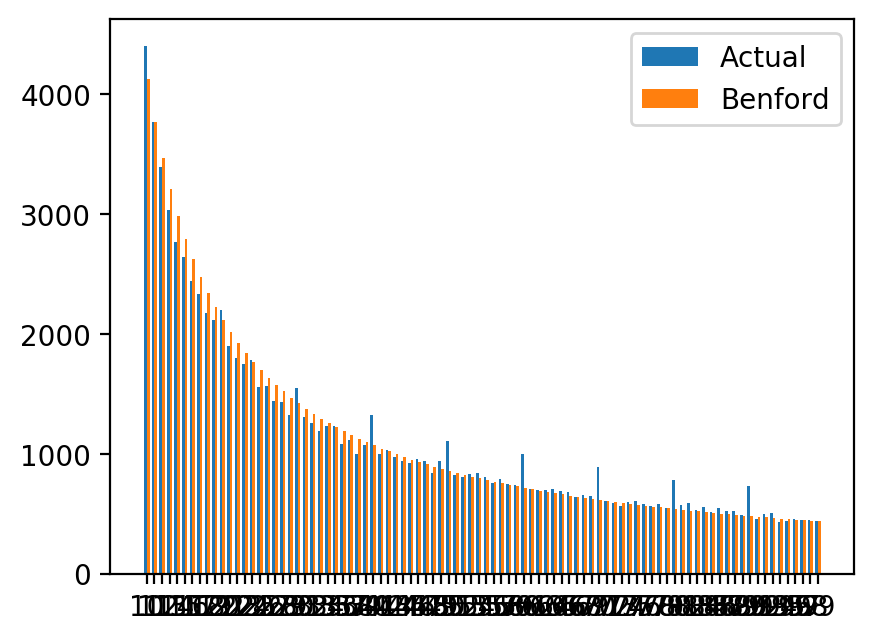

In [13]:
digit=2
data=df["field3"].tolist()
plot_benford(data,digit)

In [18]:
anomalies=[]
digit=2
data_count, expected_count, p =benford_x_digit(data,digit)
for i in range(len(data_count)):
    delta = abs(expected_count[i]-data_count[i])
    delta_sqr=(expected_count[i]-data_count[i])**2
    delta_perc=delta/expected_count[i]
    anomalies.append([range(10**(digit-1),10**digit)[i],data_count[i],expected_count[i],delta,delta_sqr, delta_perc])


In [19]:
 [i for i in anomalies if i[5]>.2]

[[40,
  1327,
  1069.6305057716208,
  257.36949422837915,
  66239.05655937169,
  0.24061532729259189],
 [50,
  1103,
  857.8069320489441,
  245.19306795105592,
  60119.640571251126,
  0.2858371258033456],
 [60,
  997,
  716.0135664631669,
  280.98643353683315,
  78953.37583174914,
  0.3924317173552991],
 [70,
  891,
  614.447671144705,
  276.55232885529495,
  76481.1905952872,
  0.45008280093255604],
 [80,
  782,
  538.1166654757309,
  243.88333452426912,
  59479.080858676556,
  0.45321646804724036],
 [90,
  735,
  478.65497527625627,
  256.34502472374373,
  65712.77170061678,
  0.5355528260743428]]

This does the Chi Square test, but tends to be problematic with high numbers due to high degrees of freedom, from the documentation you probably can't use it Benford)

In [22]:
def chisquare_test(data_count,digit):
    total_count=sum(data_count)  
    BFD= [math.log10(1.0+1.0/n) for n in range (10**(digit-1),10**digit)]
    exp_count=[int(p * total_count) for p in BFD]      
    chi_sqr, pvalue = chisquare(data_count, f_exp=exp_count) 
    return chi_sqr , pvalue
digit=2
data_count, expected_count, p =benford_x_digit(data,digit)
total_count=sum(data_count)  
data_count
chi_sqr, pvalue = chisquare_test(data_count,digit)
print("CHI square statistic:",chi_sqr)
print("p value",pvalue)


CHI square statistic: 898.2339796777127
p value 5.903330140358592e-134
